
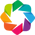

In [1]:
import os
import sys
sys.path.append('/home/user/Desktop/Thesis_Scripts/Modules')

from Tkinter import *
import Tkinter, Tkconstants, tkFileDialog
import Import_module as im
import Filtering_module as fm

import Spiker as sp

import numpy as np 

from h5py import File
import math

import time

import matplotlib
matplotlib.use('TkAgg') #Not case-sensitive
#%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade
import datashader.transfer_functions as tf
hv.extension('bokeh')

### Script purpose:
#### Exploring the neural data, spike detection, plotting with datashader

### select a dataset and open the h5 file

In [104]:
#Single file

root = Tk()
root.withdraw()#Remove the root window from the screen without removing it
path = tkFileDialog.askopenfilename(initialdir = "/home/user/Desktop/Data")
root.destroy()
print path

/home/user/Desktop/Data/2018-02-05/2011/Train/Trace_20180205_14_27_22.raw.h5


In [18]:
#Directory
root = Tk()
root.withdraw()
path = tkFileDialog.askdirectory(initialdir = "/home/user/Desktop/Data")
root.destroy()
print path

()


### Import data

In [105]:
begin = time.time()
raw = im.import_rawdata(path,0,'end',modified=False)
end = time.time()
elapsed = end - begin
print 'elapsed time: {0:.1f} seconds'.format(elapsed)

elapsed time: 2.5 seconds


In [106]:
filtdat = fm.Filtering(raw)
filtdat.butter_filter(300,3000)
filtdat.discard_out_of_bounds()
#filtdat.reshape(1000)
#raw=None

Discarded 1.0 traces.
0.0 critical traces.


In [100]:
#Spike detection: Single recording
pos_ind = sp.spiker(5,0.02,filtdat.butter_data,filtdat.metadata['time'],35000,-50)
neg_ind = sp.spiker(5,0.02,-1*filtdat.butter_data,filtdat.metadata['time'],35000,-50)

pos_spikes = [i for i in enumerate(pos_ind) if i[1]]
neg_spikes = [i for i in enumerate(neg_ind ) if i[1]]
print '{0:d} electrodes have positive spikes, {1:d} electrodes have negative spikes'.format(len(pos_spikes),len(neg_spikes))
print 'negative spikes'
print 'rel_ind.\tabs.ind.\ttimings'
for j,i in enumerate(neg_spikes):
    print j,'\t\t',i[0],'\t\t',i[1]
    
print 'positive spikes'
print 'rel_ind.\tabs.ind.\ttimings'
for j,i in enumerate(pos_spikes):
    print j,'\t\t',i[0],'\t\t',i[1]

46 electrodes have positive spikes, 28 electrodes have negative spikes
negative spikes
rel_ind.	abs.ind.	timings
0 		24 		[58754, 69460]
1 		78 		[35691]
2 		102 		[52513]
3 		118 		[124660]
4 		132 		[35202]
5 		187 		[64694]
6 		231 		[56360, 58764]
7 		239 		[35210]
8 		266 		[104887]
9 		275 		[41997, 44537]
10 		311 		[51000, 52842]
11 		322 		[40922]
12 		338 		[48243, 62022]
13 		345 		[137894, 152458]
14 		354 		[37887]
15 		356 		[35335, 57150]
16 		377 		[125394]
17 		390 		[49778]
18 		408 		[140493, 157402]
19 		410 		[36846, 47398]
20 		411 		[42766]
21 		423 		[37533, 38816]
22 		441 		[37709, 38683]
23 		452 		[41609]
24 		457 		[39050]
25 		472 		[35768, 156044]
26 		498 		[121004]
27 		509 		[35064]
positive spikes
rel_ind.	abs.ind.	timings
0 		4 		[53100, 58574, 79148, 115764]
1 		8 		[62292, 128038]
2 		19 		[35280]
3 		32 		[131548]
4 		90 		[94372, 100454, 104570]
5 		91 		[133992, 142557]
6 		118 		[118335]
7 		132 		[35214]
8 		139 		[58001, 94866, 155717]
9 		15

In [9]:
#Spike Detection: Multiple recordings: Note that filtdat.butter_data is a list.
pos_ind = [sp.spiker(4,0.03,j,filtdat.metadata[i]['time'],50,-50) for i,j in enumerate(filtdat.butter_data)]
neg_ind = [sp.spiker(4,0.03,-1*j,filtdat.metadata[i]['time'],50,-50) for i,j in enumerate(filtdat.butter_data)]

pos_spikes = [[i for i in enumerate(j) if i[1]] for j in pos_ind]
neg_spikes = [[i for i in enumerate(j) if i[1]] for j in neg_ind]
print 'Rec. \t+spike \t-spike'
for i in range(len(pos_ind)):
    print i, '\t',len(pos_spikes[i]), '\t', len(neg_spikes[i])

IndexError: index 27 is out of bounds for axis 0 with size 10

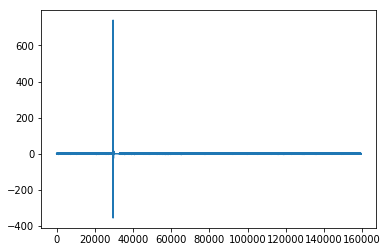

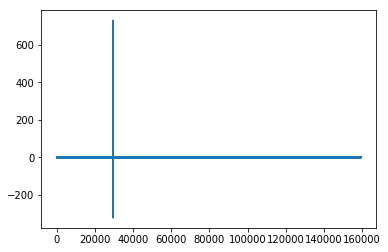

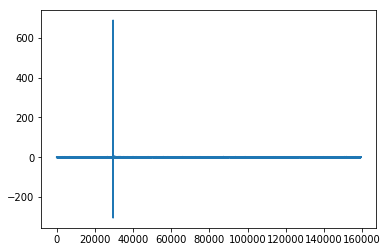

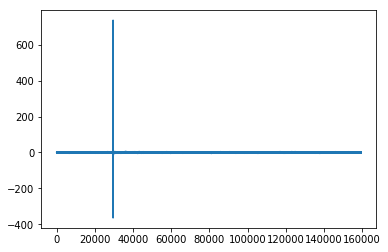

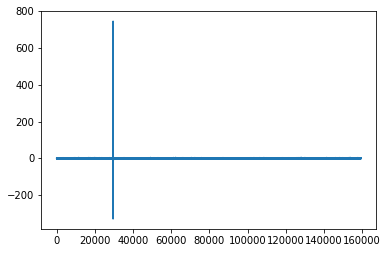

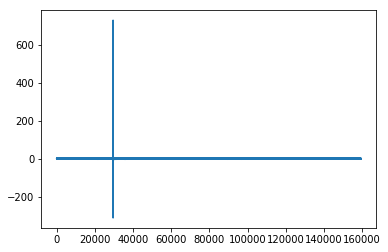

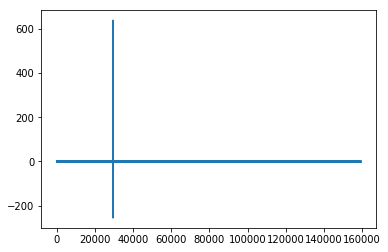

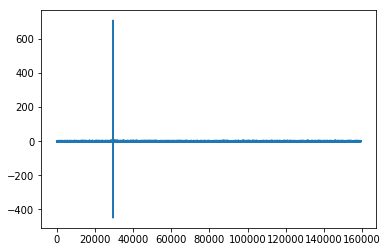

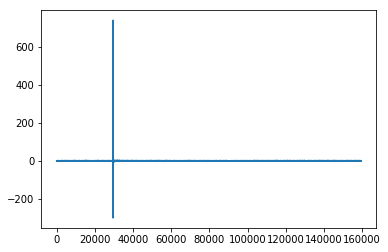

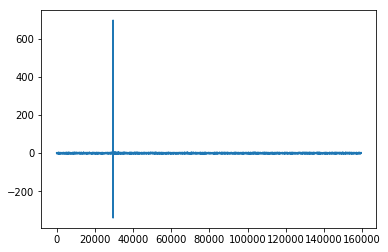

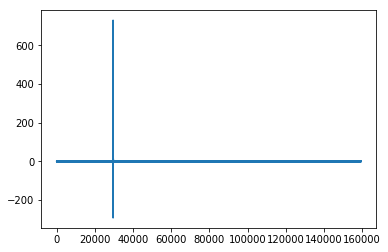

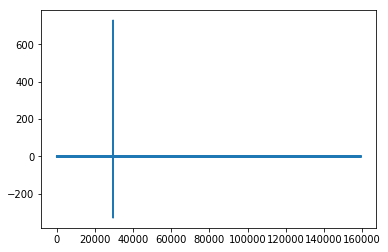

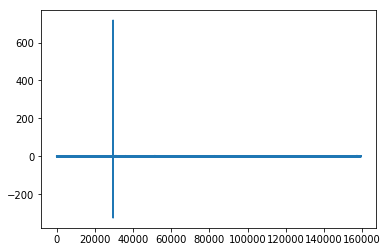

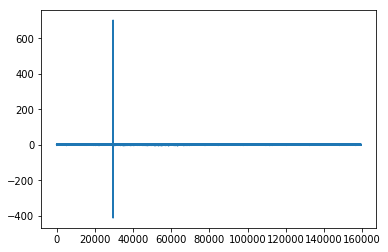

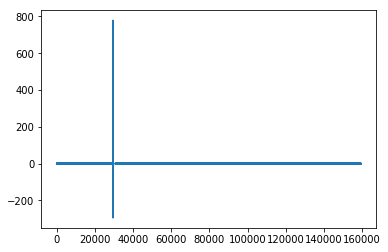

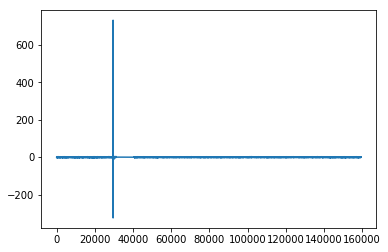

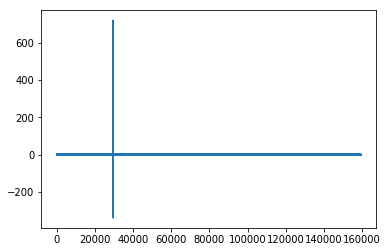

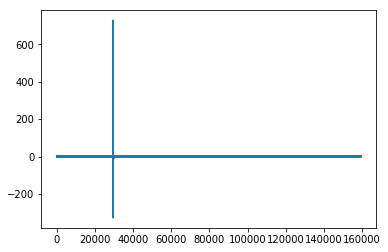

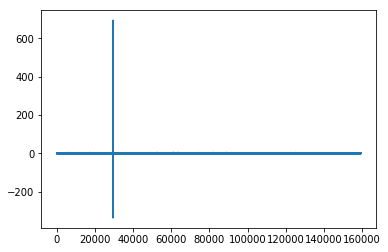

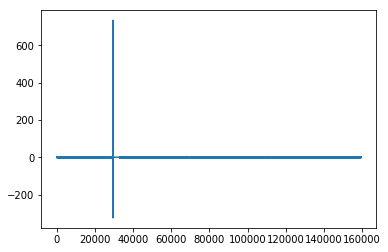

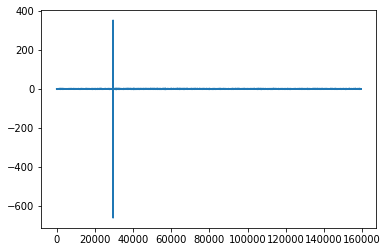

In [96]:
# Have a look at the critical traces
for i,j in enumerate(filtdat.metadata['Critical_traces']):
    if i <=20:
        plt.figure()
        plt.plot(filtdat.butter_data[j])

In [10]:
pos_spikes = [[[i for i in enumerate(j) if i[1]] for j in k] for k in pos_ind]
neg_spikes = [[[i for i in enumerate(j) if i[1]] for j in k] for k in neg_ind]
for j in range(len(pos_ind)):
    print 'Rec. \tit.\t+spike \t-spike'
    for i in range(len(pos_ind[j])):
        print j, '\t', i, '\t',len(pos_spikes[j][i]), '\t', len(neg_spikes[j][i])

NameError: name 'pos_ind' is not defined

### Plotting

In [8]:
#Show single curve
i =0
j=8
u = 20
%opts RGB [width=950,height=400]
trace_curve_butter_average = hv.Curve((filtdat.metadata[i]['time'][j,:],filtdat.raw_data[i][j,u,:]),'seconds [s]','bits')
datashade(trace_curve_butter_average,cmap=['blue'])

UsageError: Line magic function `%opts` not found.


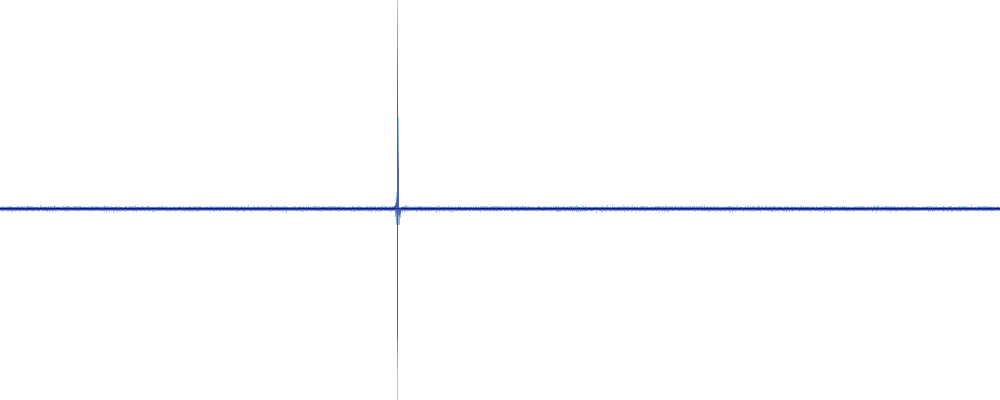

In [6]:
begin =10000
end=20000
d0 = ds.utils.dataframe_from_multiple_sequences(filtdat.metadata['time'][begin:end],filtdat.butter_data[:,begin:end])
cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(d0, 'x', 'y', ds.count())   
img0 = tf.shade(agg, how='eq_hist')
img0

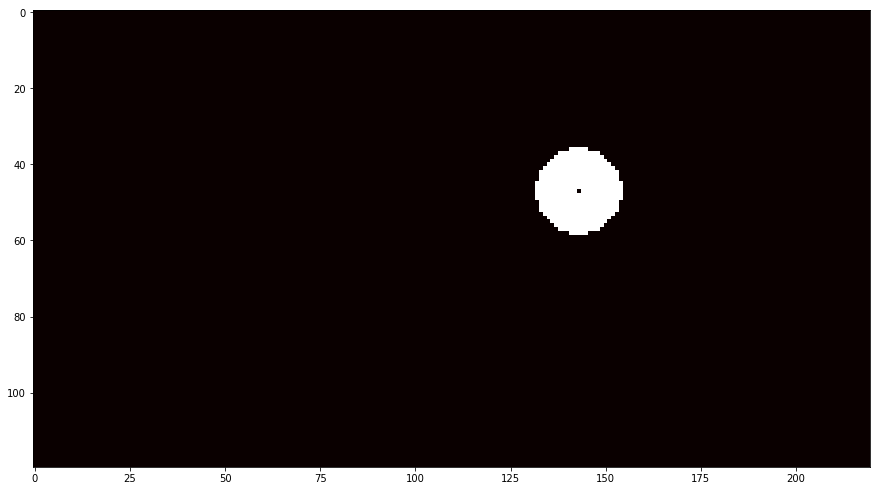

In [108]:
plt.figure(figsize=(15,10))
plt.imshow(filtdat.metadata['electrode_map'],cmap='hot')

In [74]:
%%output size=150
%%opts Curve  [height=200 width=600 tools=['hover']]
%%opts Curve (color='red' line_width=1.5)
%%opts Spikes [height=100 width=600 yaxis=None] (color='grey' line_width=1)

curve = hv.Curve(filtdat.butter_data[el_ind,:], 'Frames', 'Bits', group='Trace')
spikes = hv.Spikes(pos_spikes[abs_ind][1], kdims='Frames', vdims=[], group='Spike Train')
(curve+spikes).cols(1)

:Layout
   .Trace.I       :Curve   [Frames]   (Bits)
   .Spike_Train.I :Spikes   [Frames]

In [ ]:
%%output size=150
%%opts Spikes [height=100 width=600 yaxis=None] (color='grey' line_width=0.8)
i= 295
j= 142
o = 376
spikes1 = hv.Spikes(neg_spikes[i][1], kdims='Frames', vdims=[], group='Spike Train')
spikes2 = hv.Spikes(neg_spikes[j][1], kdims='Frames', vdims=[], group='Spike Train')
spikes3 = hv.Spikes(neg_spikes[o][1], kdims='Frames', vdims=[], group='Spike Train')
(spikes1+spikes2+spikes3).cols(1)

In [ ]:
#Spike plotting

offset_x = np.min(filtdat.metadata['x_clean'])
offset_y = np.min(filtdat.metadata['y_clean'])
span_x = np.max(filtdat.metadata['x_clean'])-np.min(filtdat.metadata['x_clean'])
span_y = np.max(filtdat.metadata['y_clean'])-np.min(filtdat.metadata['y_clean'])

matrix = np.zeros((span_y+1,span_x+1))
newpath=('/').join(path.split('/')[:-1])
timestamp=np.arange(0,len(filtdat.metadata['time']),2000)
#timestamp=np.arange(9990,10010,1)
for t in range(len(timestamp)-1):
    spikes_n = [0.1 if not i else 0.1 if not list(set(i).intersection(range(timestamp[t],timestamp[t+1]))) else 1 for i in neg_ind]
    matrix[filtdat.metadata['y_clean']-offset_y,filtdat.metadata['x_clean']-offset_x] = spikes_n
    spikes_p = [0.1 if not i else 0.1 if not list(set(i).intersection(range(timestamp[t],timestamp[t+1]))) else 0.5 for i in pos_ind]
    matrix[filtdat.metadata['y_clean']-offset_y,filtdat.metadata['x_clean']-offset_x] = spikes_p
    fig=plt.figure(figsize=(span_x/2,span_y/2))
    ax=fig.add_subplot(111)
    ax.imshow(matrix,cmap='hot',vmin=0,vmax=1,origin='lower')
    ax.set_axis_off()
    plt.savefig(path+'/'+str(t)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()

### Align and plot negative spikes

In [102]:
from matplotlib.ticker import FormatStrFormatter

/home/user/anaconda2/envs/ds/lib/python2.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


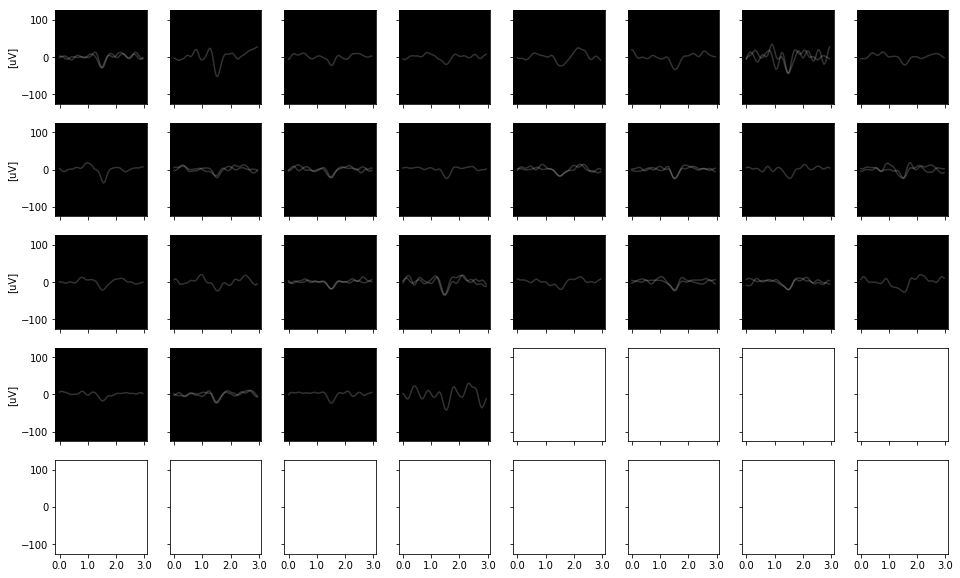

In [103]:
num_hor_plot=8
#num_ver_plots=int(np.ceil(len(neg_spikes[Rec_no])/float(num_hor_plot)))
num_ver_plots=5
plot_square_size=2
trace_stack = []
uV_conv = 6.29

fig,axarr=plt.subplots(num_ver_plots,num_hor_plot,figsize=(plot_square_size*num_hor_plot,plot_square_size*num_ver_plots),sharex=True,sharey=True)
for ids,s in enumerate(neg_spikes):
    if ids==num_hor_plot*num_ver_plots:
        break
        pass
    for i in s[1]:
        ver_idx=ids/num_hor_plot
        hor_idx=ids%num_hor_plot
        axarr[ver_idx,hor_idx].plot(filtdat.butter_data[s[0],i-30:i+30]*uV_conv,alpha=0.2,color='w')
        trace_stack.append(filtdat.butter_data[s[0],i-30:i+30])
    #axarr[ver_idx,hor_idx].set_title(str(s[0])+' index:'+str(ids))
    axarr[ver_idx,hor_idx].set_axis_bgcolor('k')
    axarr[ver_idx,hor_idx].set_ylim(-20*uV_conv,20*uV_conv)
    if hor_idx == 0:
        axarr[ver_idx,hor_idx].set_ylabel('[uV]')
    axarr[ver_idx,hor_idx].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axarr[ver_idx,hor_idx].set_xticks(np.linspace(0,60*0.05,4)*20)
    axarr[ver_idx,hor_idx].set_xticklabels(np.linspace(0,60*0.05,4))
    if ver_idx == num_ver_plots-1:
        axarr[ver_idx,hor_idx].set_xlabel('[ms]')
    
plt.subplots_adjust(wspace=.25)

#plt.savefig('aligned_spikes.png',dpi=500,bbox_inches='tight',pad_inches=0)

### Align and plot positive spikes

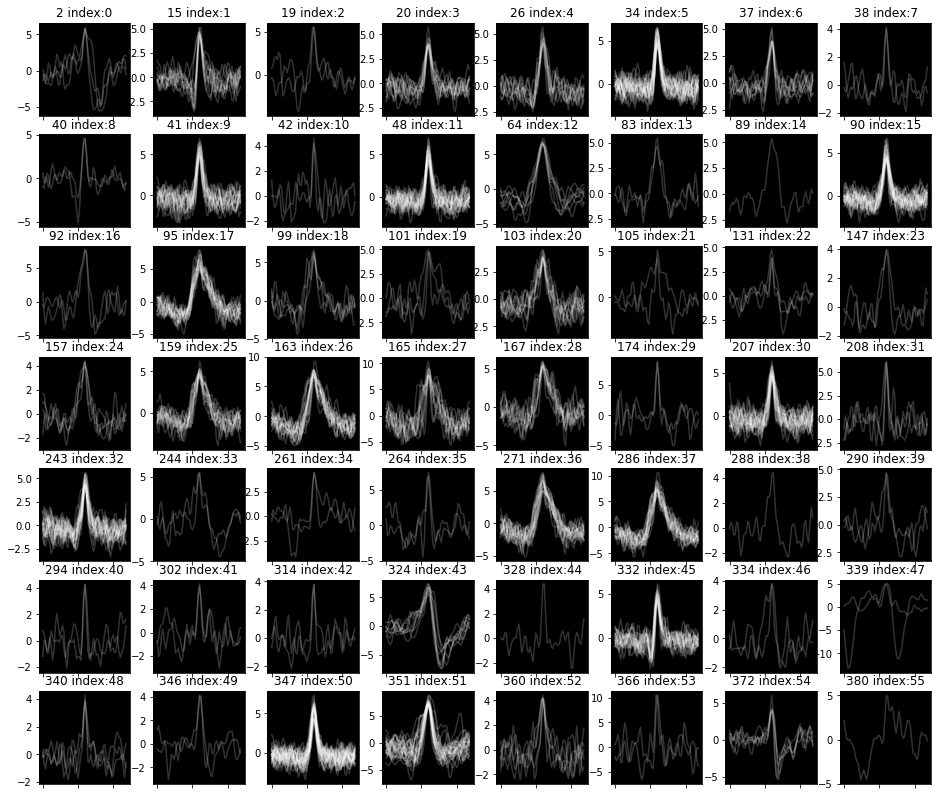

In [13]:
#Rec_no = 1
num_hor_plot=8
#num_ver_plots=int(np.ceil(len(pos_spikes)/float(num_hor_plot)))
num_ver_plots=7
plot_square_size=2

fig,axarr=plt.subplots(num_ver_plots,num_hor_plot,figsize=(plot_square_size*num_hor_plot,plot_square_size*num_ver_plots))
for ids,s in enumerate(pos_spikes):
    if ids==num_hor_plot*num_ver_plots:
        break
        pass
    for i in s[1]:
        ver_idx=ids/num_hor_plot
        hor_idx=ids%num_hor_plot
        axarr[ver_idx,hor_idx].plot(filtdat.butter_data[s[0],i-30:i+30],alpha=0.2,color='w')
    axarr[ver_idx,hor_idx].set_title(str(s[0])+' index:'+str(ids))
    axarr[ver_idx,hor_idx].set_facecolor('k')
    axarr[ver_idx,hor_idx].set_xticklabels([])
    
plt.subplots_adjust(wspace=.25)
#plt.savefig(path[:-11]+'/aligned_peaks.png',bbox_inches='tight',pad_inches=0,dpi=200)
#plt.close()

### PCA on Traces

In [24]:
from matplotlib.mlab import PCA
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook
%matplotlib notebook


In [9]:
from sklearn.decomposition import PCA

In [19]:
results = PCA(n_components = 3).fit(trace_stack)

In [20]:
scores = results.score_samples(trace_stack)
print scores.shape

(12229,)


In [105]:
el_ind = 60
trace_stack = []
for i in neg_spikes[el_ind][1]:
    trace_stack.append(filtdat.butter_data[neg_spikes[el_ind][0],i-12:i+12])

<IPython.core.display.Javascript object>


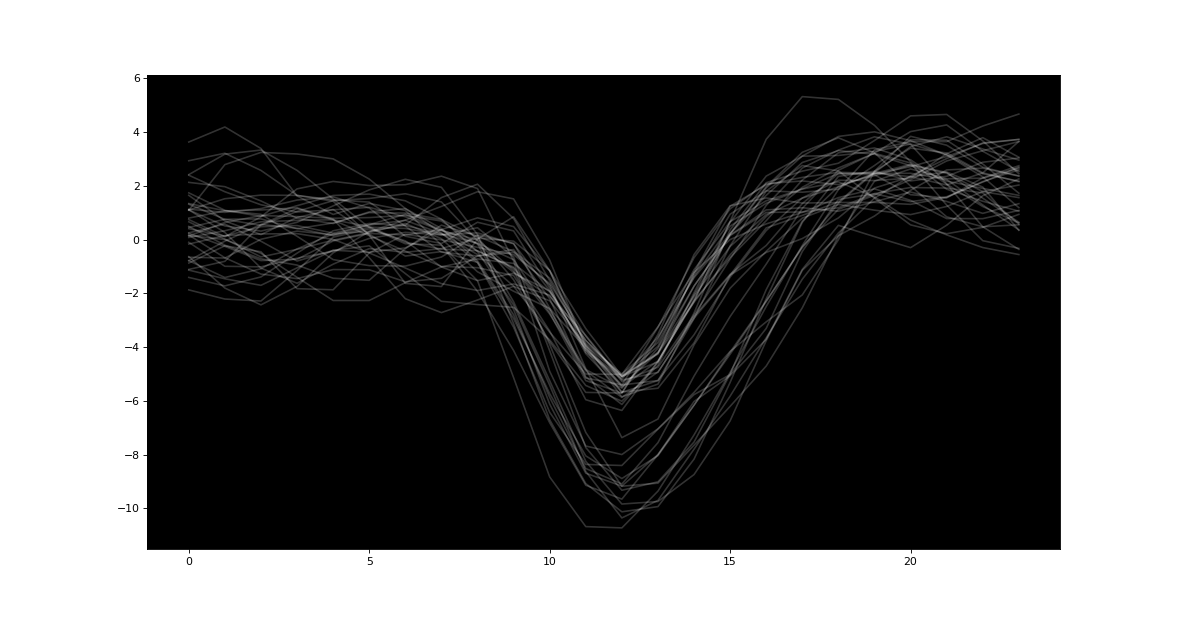

In [106]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
for i in trace_stack:
    ax.plot(i,alpha=0.2,color='w')
ax.set_facecolor('k')
plt.show()

In [25]:
result = PCA(np.asarray(trace_stack))

<IPython.core.display.Javascript object>


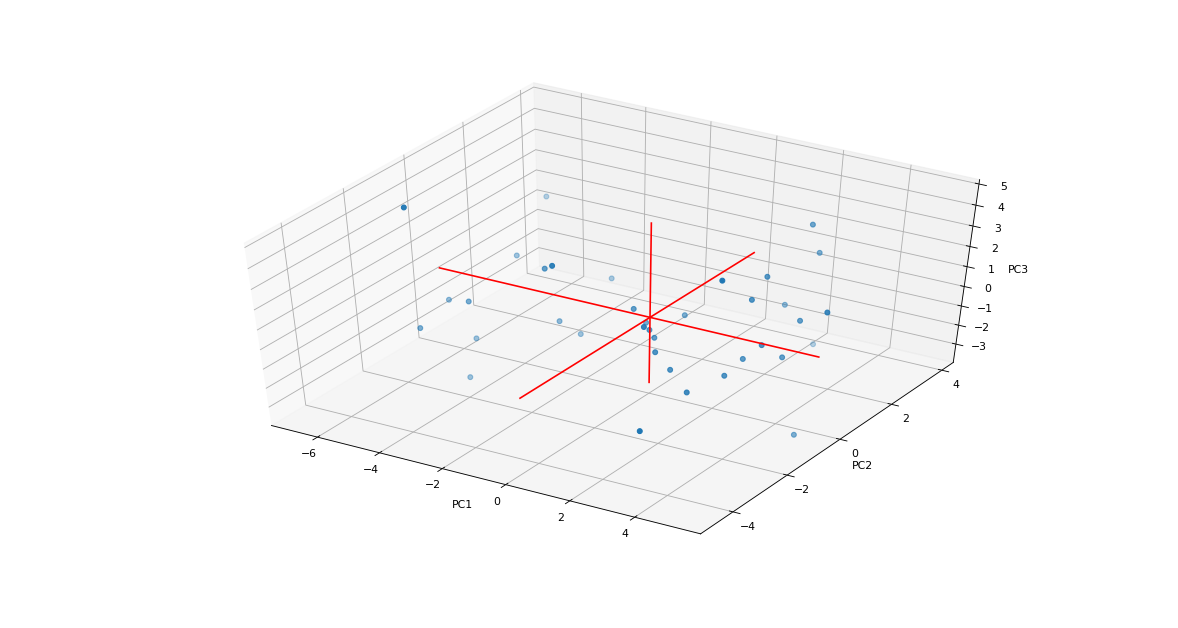

In [108]:
x = []
y = []
z = []
for item in result.Y:
 x.append(item[0])
 y.append(item[1])
 z.append(item[2])

Fig,ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(15,8))
pltData = [x,y,z] 
ax.scatter(pltData[0], pltData[1], pltData[2])
 
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
 
# label the axes 
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
#ax.set_title("The title of the plot")
plt.show() # show the plot